Accuracy: 0.8715596330275229
Precision: 0.8482936199590202
Recall: 0.8715596330275229
F1 Score: 0.6610680186402343
AUC: 0.8104546087913684
V Score: 0.8016176237705758


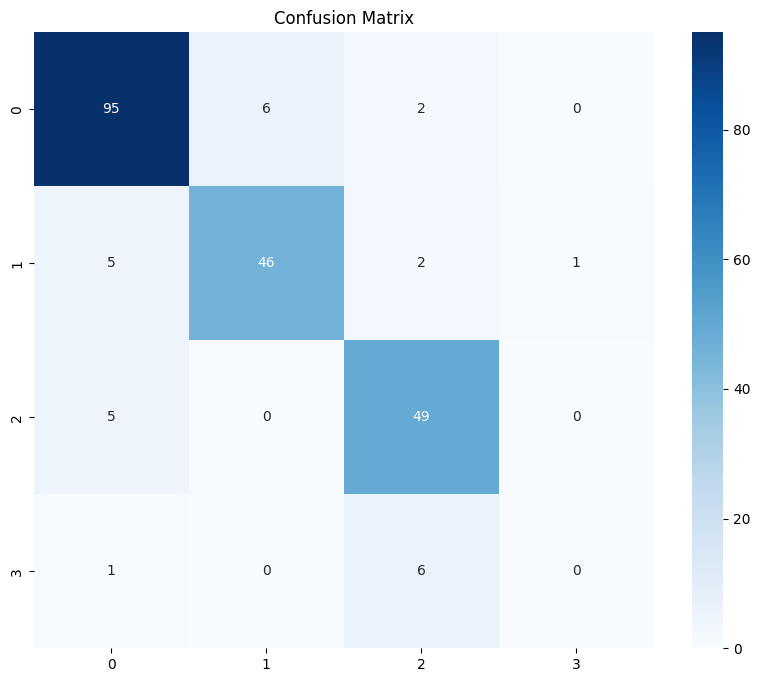

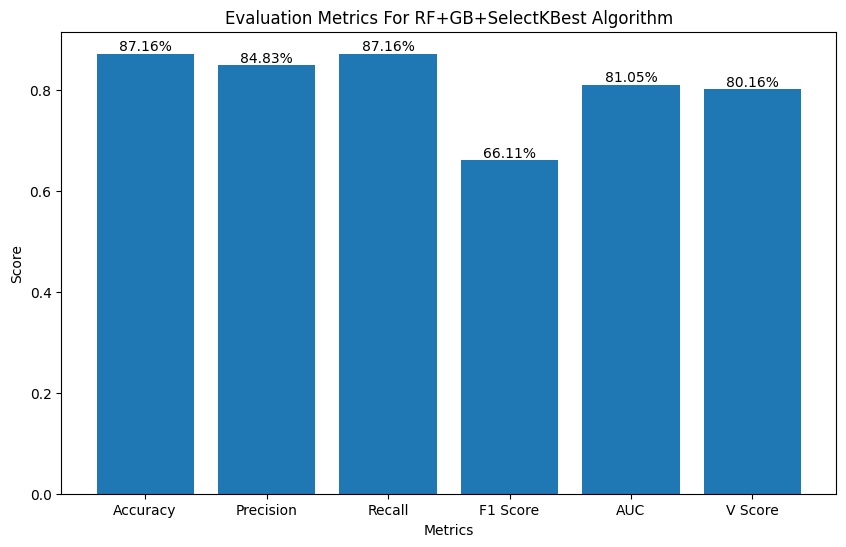

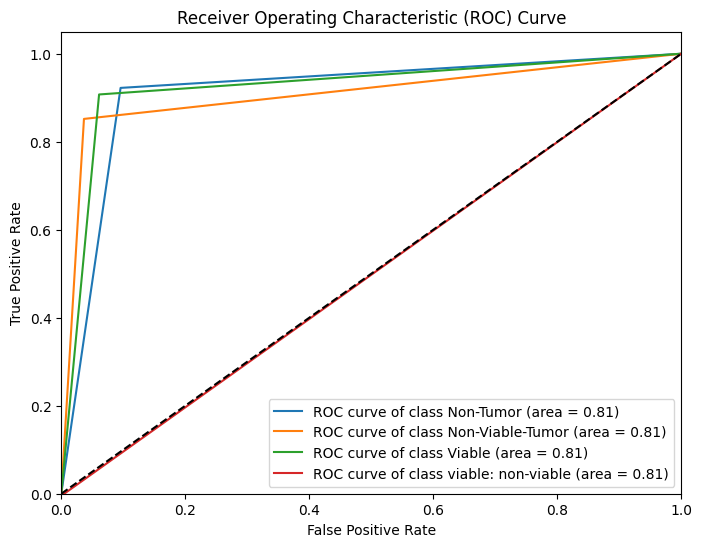

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (607,).

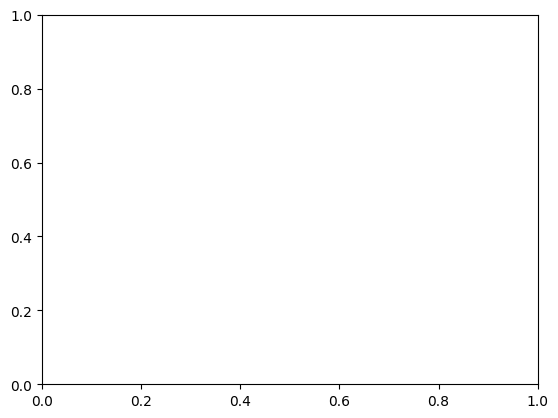

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize

# Load the dataset from a CSV file
dataset_path = r'C:\Users\tahsi\OneDrive\Desktop\python_ws\dataset_NoPCA.csv'
df = pd.read_csv(dataset_path)

# Separate the features and target variable
X = df.drop('classification', axis=1)
y = df['classification']

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace NaN values with column mean
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the first classifier (Random Forest)
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf1.fit(X_train, y_train)

# Train the second classifier (Gradient Boosting)
clf2 = GradientBoostingClassifier(n_estimators=50, random_state=42)
clf2.fit(X_train, y_train)

# Make predictions using both classifiers
pred1 = clf1.predict(X_test)
pred2 = clf2.predict(X_test)

# Generate predicted probabilities for the combined predictions
y_pred_proba_1 = clf1.predict_proba(X_test)
y_pred_proba_2 = clf2.predict_proba(X_test)

# Combine the predicted probabilities using plurality voting
y_pred_proba_combined = np.maximum(y_pred_proba_1, y_pred_proba_2)

# Convert the predicted probabilities to a DataFrame
class_names = np.unique(y)
y_pred_proba_df = pd.DataFrame(y_pred_proba_combined, columns=class_names)

# Combine predictions using plurality voting
combined_pred = np.array([max(set([pred1[i], pred2[i]]), key=list([pred1[i], pred2[i]]).count) for i in range(len(pred1))])

# Calculate accuracy, precision, recall, F1 score, AUC, and V score of the combined predictions
accuracy = accuracy_score(y_test, combined_pred)
precision = precision_score(y_test, combined_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, combined_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, combined_pred, average='macro')
auc = roc_auc_score(label_binarize(y_test, classes=class_names), label_binarize(combined_pred, classes=class_names), average='macro')
v_score = matthews_corrcoef(y_test, combined_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)
print("V Score:", v_score)

# Calculate and visualize the confusion matrix
cm = confusion_matrix(y_test, combined_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Create a histogram for the evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'V Score']
values = [accuracy, precision, recall, f1, auc, v_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics For RF+GB+Whole data Algorithm')

# Add text annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom')

plt.show()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=class_names)[:, i], label_binarize(combined_pred, classes=class_names)[:, i])
    plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute precision and recall for each class
precision = dict()
recall = dict()
for class_index, class_name in enumerate(class_names):
    # Convert the class labels to binary (one-vs-rest)
    y_true_binary = (y_test == class_name).astype(int)
    y_pred_proba_binary = y_pred_proba_df[class_name]

    # Check if there is at least one positive class
    if np.sum(y_true_binary) > 0:
        # Compute precision and recall for the current class
        precision[class_name], recall[class_name], _ = precision_recall_curve(y_true_binary, y_pred_proba_binary)
    else:
        # Set precision and recall to empty arrays
        precision[class_name] = np.array([])

# Define colors for precision and recall bars
precision_color = 'blue'
recall_color = 'green'

# Flatten the precision and recall values
precision_values = np.concatenate([precision[class_name] for class_name in class_names])
recall_values = np.concatenate([recall[class_name] for class_name in class_names])

# Plot precision bars
index = np.arange(len(class_names))
bar_width = 0.35
plt.bar(index, precision_values, bar_width, label='Precision', color=precision_color)

# Plot recall bars with different color
plt.bar(index, recall_values, bar_width, label='Recall', color=recall_color, alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall by Class')
plt.xticks(index, class_names)
plt.legend()
plt.show()
